## Overview of the method

In this notebook, we reproduce the Figure 1 of the original [paper](https://arxiv.org/pdf/2310.14814.pdf) that illustrates our method. 

In [3]:
%reload_ext autoreload
%autoreload 2

In [17]:
import os

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from scipy.special import expit as sigmoid

In [18]:
class Preprocessing:
    def __init__(
        self,
    ):
        pass

    def fit_transform(self, X):
        mean = np.mean(X, axis=0)
        sigma = np.var(X, axis=0)
        sigma = np.array((sigma > 0), dtype=float) * sigma + np.array(
            (sigma == 0), dtype=float
        )
        self.mean = mean
        self.sqrt_sigma = np.sqrt(sigma)
        return (X - self.mean) / self.sqrt_sigma

    def transform(self, X):
        return (X - self.mean) / self.sqrt_sigma


def linear_decision(omega, x):
    omega /= (omega**2).sum(axis=0)
    w0, w1 = omega
    b = 0
    return -w0 / w1 * x - b / w1


class MyLinearSVC(LinearSVC):
    def __init__(self, C, fit_intercept):
        super().__init__(C=C, fit_intercept=fit_intercept)

    def predict_proba(self, x, c=1, matrix=False):
        prob_1 = sigmoid(c * self.decision_function(x))
        if matrix:
            return np.vstack([prob_1, 1 - prob_1]).T
        else:
            return prob_1


def similarity(x, clfs):
    M = len(clfs)
    sim = 0
    for i in range(M):
        for j in range(M):
            if i == j:
                continue
            else:
                sim += np.dot(
                    clfs[i].predict_proba(x, matrix=True)[0],
                    clfs[j].predict_proba(x, matrix=True)[0],
                )
    sim /= M * (M - 1)
    return sim

In [21]:
n_samples = 1000
x, y = make_classification(
    n_samples=n_samples,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    shuffle=True,
    flip_y=False,
    class_sep=2,
    n_clusters_per_class=1,
    random_state=0,
)

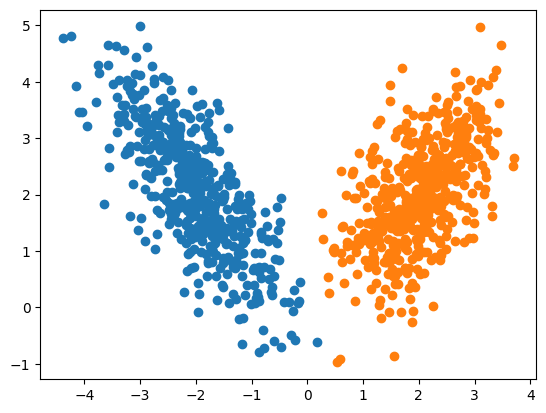

In [20]:
plt.scatter(x[y == 0, 0], x[y == 0, 1])
plt.scatter(x[y == 1, 0], x[y == 1, 1])
plt.show()

In [19]:
idx_l = np.array([689, 747, 544, 749, 508, 538, 461, 560, 754, 709])
idx_u = np.setdiff1d(np.arange(x.shape[0]), idx_l)

In [22]:
x_l, y_l = x[idx_l], y[idx_l]
x_u, y_u = x[idx_u], y[idx_u]
prep = Preprocessing()
x_l = prep.fit_transform(x_l)
x_u = prep.transform(x_u)

In [23]:
clfs = []
for c in [1e-5, 1e2]:
    clfs.append(MyLinearSVC(C=c, fit_intercept=False).fit(X=x_l, y=y_l))
clfs.append(MyLinearSVC(C=c, fit_intercept=False).fit(X=x, y=y))
clf_horiz = MyLinearSVC(C=c, fit_intercept=False).fit(X=x_l, y=y_l)
clf_horiz.coef_ = np.array([[0.15, -1]])
clfs.append(clf_horiz)

sims = np.array([similarity(x_u[[i]], clfs) for i in range(x_u.shape[0])])

In [25]:
sim_probs = 0.5 + 0.5 * np.sign(clfs[0].decision_function(x_u)) * (
    sims - sims.min()
) / (sims.max() - sims.min())

In [ ]:
def get_intro_plot(
    figsize=(10, 4), save=False, path="figures", filename=None, dpi=100, format="pdf"
):
    lw = 2
    fontsize = 20
    color1, color2 = "#2F5D8C", "#D55E2D"

    cmap = LinearSegmentedColormap.from_list(
        "rg", [(0, color1), (0.43, "grey"), (0.58, "grey"), (1, color2)], N=256
    )

    gridspec = {"width_ratios": [1, 1, 0.05]}
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize, gridspec_kw=gridspec)

    cond = (x_u[:, 1] < 3.9) & (-3.9 < x_u[:, 1])

    imgs = []
    for i in range(2):
        axes[i].scatter(
            x_l[y_l == 0, 0],
            x_l[y_l == 0, 1],
            c=color1,
            marker="^",
            s=180,
            zorder=3,
            linewidth=1.2,
            edgecolors="black",
            label="labeled class 0",
        )
        axes[i].scatter(
            x_l[y_l == 1, 0],
            x_l[y_l == 1, 1],
            c=color2,
            marker="s",
            s=130,
            zorder=3,
            linewidth=1.2,
            edgecolors="black",
            label="labeled class 1",
        )

        if i == 0:
            imgs.append(
                axes[i].scatter(
                    x_u[cond, 0],
                    x_u[cond, 1],
                    c=clfs[0].predict_proba(x_u, c=5000)[cond],
                    alpha=0.85,
                    cmap=cmap,
                    zorder=1,
                )
            )
            clf = clfs[0]
            w, b = clf.coef_[0], 0
            x_points = np.linspace(-3, 3)  # generating x-points from -1 to 1
            y_points = -(w[0] / w[1]) * x_points - b / w[1]
            axes[i].plot(x_points, y_points, c="k", linewidth=lw)
        elif i == 1:
            imgs.append(
                axes[i].scatter(
                    x_u[cond, 0],
                    x_u[cond, 1],
                    c=sim_probs[cond],
                    alpha=0.85,
                    cmap=cmap,
                    zorder=1,
                )
            )
            for j, clf in enumerate(clfs):
                #         for clf in clfs:
                w = clf.coef_[0].copy()  # w consists of 2 elements
                if j == 3:
                    w[0] += 0.1
                b = 0
                x_points = np.linspace(-3, 3)  # generating x-points from -1 to 1
                y_points = -(w[0] / w[1]) * x_points - b / w[1]
                axes[i].plot(x_points, y_points, c="k", linewidth=lw)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_ylim(-4.05, 4.05)
        axes[i].set_xlim(-2.5, 2.5)
        axes[i].set_autoscaley_on(False)
    axes[0].set_title("Softmax \n", fontsize=fontsize)
    axes[1].set_title("$\mathcal{T}$-similarity \n", fontsize=fontsize)

    for i, ax in enumerate(axes):
        if i < 2:
            ax.axis("off")
    fig.colorbar(imgs[0], cax=axes[2])
    fig.tight_layout()
    if save:
        if filename is None:
            filename = f"missing_title.{format}"
        plt.savefig(
            os.path.join(path, filename), format=format, bbox_inches="tight", dpi=dpi
        )
    plt.show()

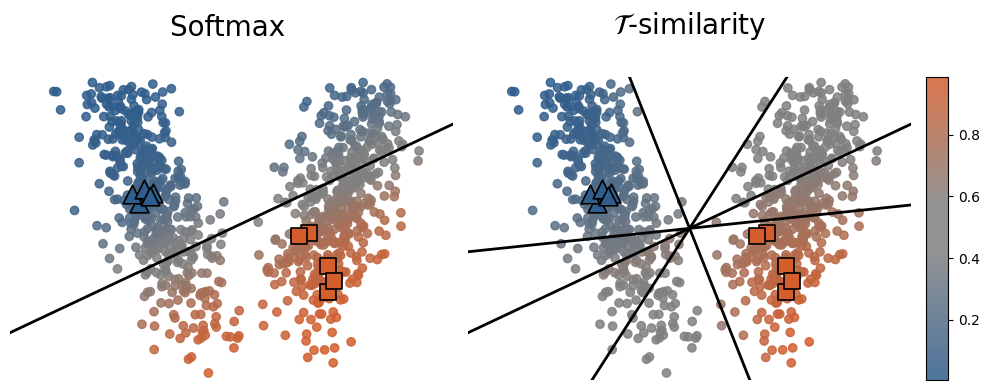

In [26]:
figsize = (10, 4)
save = True
path = "figures"
filename = f"intro_plot.{format}"
dpi = 100
format = "pdf"
get_intro_plot(
    path=path,
    save=save,
    filename=filename,
    figsize=figsize,
    format=format,
    dpi=dpi,
)